In [7]:
import json
import pandas as pd
import seaborn as sns; sns.set()
import babeltrace as bl

In [8]:
tr = bl.TraceCollection()
tr.add_trace('sample_traces/jsoo/ctf', "ctf")

events = []
counters = []
allocs = []

ENTRY = 0
EXIT = 1
COUNTER = 2
ALLOC = 3


# babeltrace is an evil binding, do not put Event objects directly in a list, need to hard copy them.
# Events objects are actually references to the head of the iterator, so trying to use them from outside
# the scope of the iterator will results in having the same objects, that is, the last object iterated upon.
# ¯\_(ツ)_/¯

for event in tr.events:
    id = event['id']
    ev = {}
    ev['timestamp'] = event['timestamp']
    if id == ENTRY or id == EXIT:
        ev['phase'] = event['phase']
        ev['id'] = id
        events.append(ev)
    if id == COUNTER:
        ev['name'] = event['kind']
        ev['count'] = event['count']
        counters.append(ev)
    if id == ALLOC:
        ev['bucket'] = event['bucket']
        ev['count'] = event['count']
        allocs.append(ev)
    
timeline_set = {}
timeline = []

for event in events:
    phase = event['phase']
    if event['id'] == ENTRY:
        if phase in timeline_set:
            print("overlapping entry for phase: %s, timestamp %d" % (phase, event['timestamp']))
        else:
            timeline_set[phase] = event
    elif event['id'] == EXIT:
        if phase in timeline_set: 
            ev_entry = timeline_set[phase]
            item = {
                'ts_begin': ev_entry['timestamp'],
                'ts_end': event['timestamp'],
                'dur' : event['timestamp'] - ev_entry['timestamp'],
                'phase': phase
            }
            timeline.append(item)
            del timeline_set[phase]
        else:
            print("got an exit event with no entry: %s, timestamp %d" % (phase, event['timestamp']))
    
for key in timeline_set:
    print("got an entry event with no exit: %s, timestamp: %d" % (key, timeline_set[key]['timestamp']))

# FIXME: none of these should be tolerable besides impromptu program shutdown (segfault, abort... ect)

got an exit event with no entry: major/mark_final, timestamp 4825128
overlapping entry for phase: major/mark_roots, timestamp 11983480
got an exit event with no entry: major/mark_final, timestamp 13656935
overlapping entry for phase: major/mark_roots, timestamp 21288580
got an exit event with no entry: major/mark_final, timestamp 26077514
overlapping entry for phase: major/mark_roots, timestamp 34357892
got an exit event with no entry: major/mark_final, timestamp 40564907
overlapping entry for phase: major/mark_roots, timestamp 49507346
got an exit event with no entry: major/mark_main, timestamp 59133890
got an exit event with no entry: major/mark_final, timestamp 61191983
overlapping entry for phase: major/mark_roots, timestamp 76844490
got an exit event with no entry: major/mark_final, timestamp 95465765
overlapping entry for phase: major/mark_roots, timestamp 118788736
got an exit event with no entry: major/mark_final, timestamp 125912431
overlapping entry for phase: major/mark_root

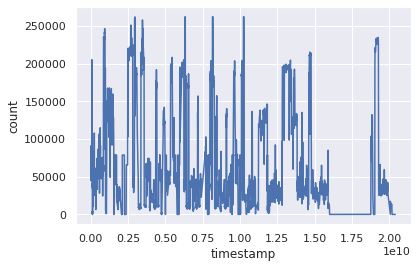

In [9]:
# From here, refer to https://github.com/Engil/gc-tracing/blob/master/metadata to know
# the various phases and counters available.

def counters_by_name(name): return [ev for ev in counters if ev['name'] == name]
def events_by_name(name): return [ev for ev in timeline if ev['phase'] == name]

s = pd.DataFrame(counters_by_name('minor/promoted'))

s['timestamp'] = s['timestamp'].astype('timedelta64[ns]')

sns.lineplot(x="timestamp", y="count", data=s)


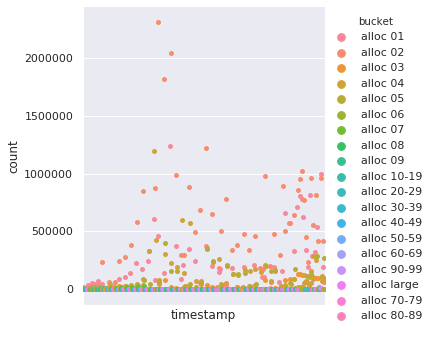

In [10]:
# Visiting allocations during the lifetime of the program, by buckets

s = pd.DataFrame(allocs)

ax = sns.catplot(x='timestamp', y='count', hue='bucket', data=s)
ax.set(xticks=[])


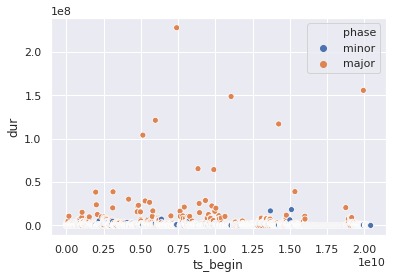

In [11]:
# minor and major dispatches, duration on the Y axis
s = pd.DataFrame([ev for ev in timeline if ev['phase'] == 'major' or ev['phase'] == 'minor'])
ax = sns.scatterplot(x='ts_begin', y='dur', hue='phase', data=s)

In [12]:
def gc_phase_quantile(name):
    s = pd.DataFrame(events_by_name(name))
    #s['timestamp'] = s['timestamp'].astype('timedelta64[ns]')
    return (s['dur'].quantile([.1, .25, .50, .75, .95, .99]))

In [13]:
gc_phase_quantile('major')

0.10        8234.40
0.25      162240.00
0.50      477792.00
0.75     1172755.50
0.95     3855911.30
0.99    10411310.18
Name: dur, dtype: float64

In [14]:
gc_phase_quantile('minor')

0.10      77132.40
0.25     149607.00
0.50     396085.00
0.75     692175.00
0.95    2578264.40
0.99    3257261.36
Name: dur, dtype: float64

In [15]:
gc_phase_quantile('major/sweep')

0.10       2395.20
0.25     119395.50
0.50     350880.50
0.75     627666.75
0.95    2317725.45
0.99    4270188.74
Name: dur, dtype: float64